# Setup

In [1]:
%matplotlib inline

In [2]:
# Library imports

from fastai import *
from fastai.vision.all import *
from nbdev.showdoc import *
import torchvision

set_seed(42) # for reproducible random numbers

In [3]:
# Change this to another device (0-7) if you run out of memory
# Goto Kernel->Restart&Clear Output after changing the device
torch.cuda.set_device(2)

In [4]:
# Batch size: https://docs.paperspace.com/machine-learning/wiki/epoch
# Typically 32 works fine, feel free to experiment with it
# If you run out of memory, try to lower the number
bs = 32

# Get Data

We'll use the MNIST Dataset (http://yann.lecun.com/exdb/mnist/) and try to predict handwritten digits.

Here's a list of available datasets: https://docs.fast.ai/data.external.html

In [5]:
path = Path('plant_seedlings_v2'); path.ls()

(#12) [Path('plant_seedlings_v2/black_grass'),Path('plant_seedlings_v2/charlock'),Path('plant_seedlings_v2/cleavers'),Path('plant_seedlings_v2/common_chickweed'),Path('plant_seedlings_v2/common_wheat'),Path('plant_seedlings_v2/fat_hen'),Path('plant_seedlings_v2/loose_silky_bent'),Path('plant_seedlings_v2/maize'),Path('plant_seedlings_v2/scentless_mayweed'),Path('plant_seedlings_v2/shepherds_purse')...]

# Step 1 - Data Loader

In [6]:
fnames = get_image_files(path)
fnames

(#5539) [Path('plant_seedlings_v2/black_grass/1.png'),Path('plant_seedlings_v2/black_grass/10.png'),Path('plant_seedlings_v2/black_grass/100.png'),Path('plant_seedlings_v2/black_grass/101.png'),Path('plant_seedlings_v2/black_grass/102.png'),Path('plant_seedlings_v2/black_grass/103.png'),Path('plant_seedlings_v2/black_grass/104.png'),Path('plant_seedlings_v2/black_grass/105.png'),Path('plant_seedlings_v2/black_grass/106.png'),Path('plant_seedlings_v2/black_grass/107.png')...]

In [7]:
#df = pd.read_csv(path/"png.csv")

In [8]:
def label_func(path): 
    dir_name = os.path.dirname(path)
    split_dir_name = dir_name.split("/")
    dir_length = len(split_dir_name)
    label = split_dir_name[dir_length - 1]
    return(label)

In [9]:
#dsets.vocab

In [10]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

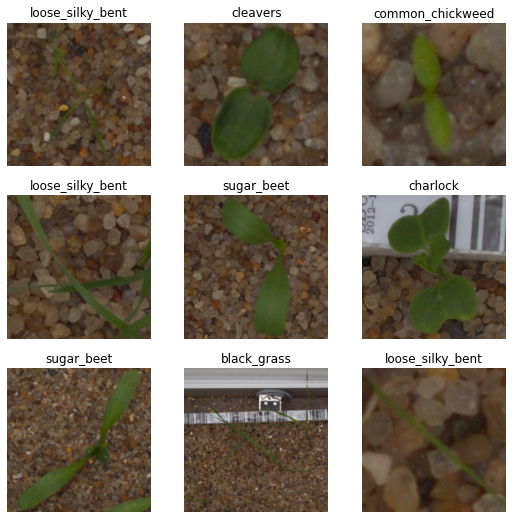

In [11]:
dls = dblock.dataloaders(path)
dls.show_batch()

In [12]:
print(dls.vocab)
len(dls.vocab)


['black_grass', 'charlock', 'cleavers', 'common_chickweed', 'common_wheat', 'fat_hen', 'loose_silky_bent', 'maize', 'scentless_mayweed', 'shepherds_purse', 'small_flowered_cranesbill', 'sugar_beet']


12

# Step 2 - Building a Model

In [13]:
learner = cnn_learner(dls, resnet152, metrics=error_rate) #.to_fp16()

In [14]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

# Step 3 - Learning

In [15]:
learner.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.680576,0.430365,0.134598,00:28
1,0.647858,0.247742,0.093948,00:27
2,0.283663,0.202069,0.065944,00:27
3,0.147239,0.206346,0.066847,00:27
4,0.074060,0.194002,0.062331,00:27
5,0.044882,0.195114,0.060524,00:27


In [16]:
learner.save('stage-1')

Path('models/stage-1.pth')

In [17]:
print("Accuracy: ", 1-float(learner.recorder.metrics[0].value))

Accuracy:  0.9394760616123676


In [18]:
interpretation = ClassificationInterpretation.from_learner(learner)

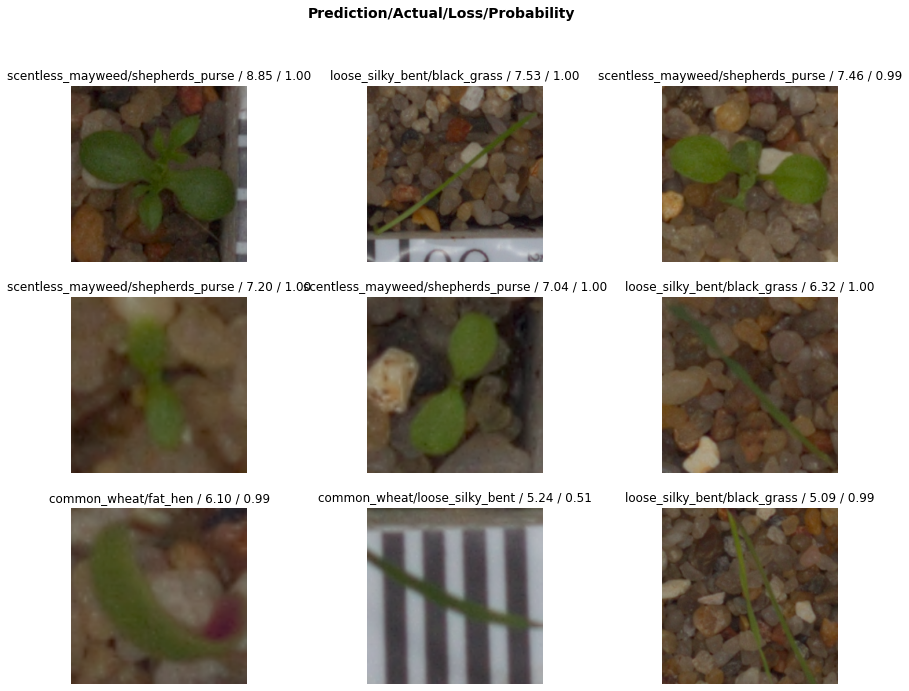

In [19]:
interpretation.plot_top_losses(9, figsize=(15,11))

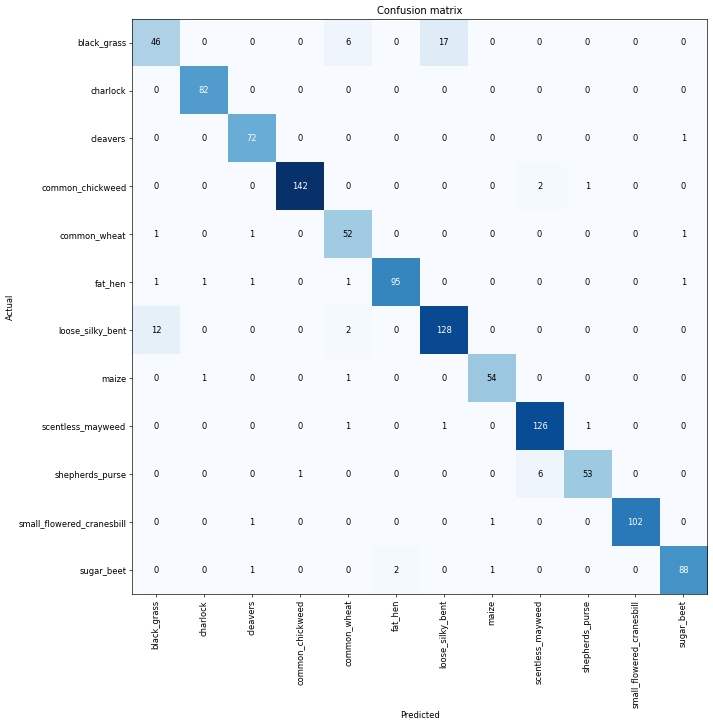

In [20]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interpretation.most_confused(min_val=2)

[('black_grass', 'loose_silky_bent', 17),
 ('loose_silky_bent', 'black_grass', 12),
 ('black_grass', 'common_wheat', 6),
 ('shepherds_purse', 'scentless_mayweed', 6),
 ('common_chickweed', 'scentless_mayweed', 2),
 ('loose_silky_bent', 'common_wheat', 2),
 ('sugar_beet', 'fat_hen', 2)]

/home/ele_group_3/miniconda3/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0003981071640737355)

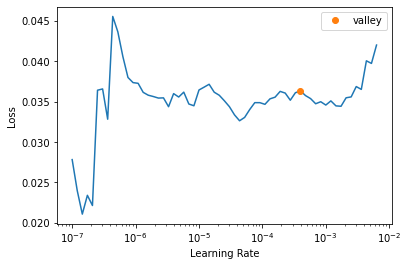

In [22]:
learner.lr_find()

In [23]:
learner.save('stage-1')

Path('models/stage-1.pth')

In [24]:
learner.unfreeze()
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.849525,0.395852,0.146341,00:36


SuggestedLRs(valley=7.585775892948732e-05)

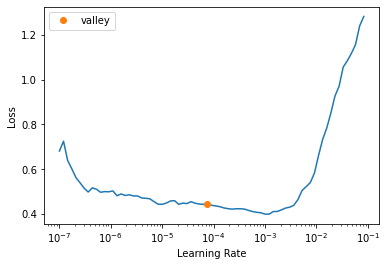

In [25]:
learner.lr_find()

In [26]:
learner.unfreeze()
learner.fit_one_cycle(3, lr_max=slice(1e-5,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.346252,0.250022,0.096658,00:36
1,0.241054,0.208983,0.083108,00:36
2,0.158905,0.167567,0.063234,00:35


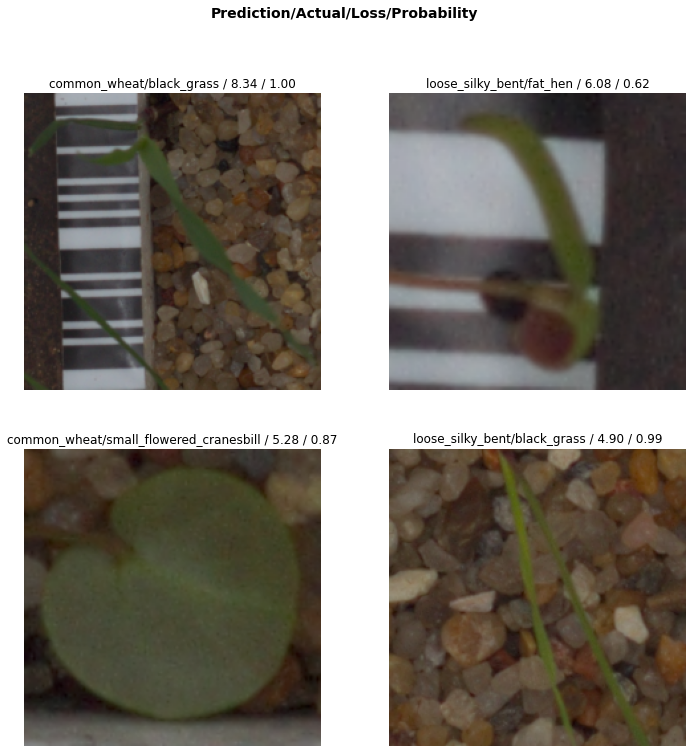

In [27]:
interpretation = ClassificationInterpretation.from_learner(learner)
losses, indices = interpretation.top_losses()
interpretation.plot_top_losses(4, figsize=(12,12))

In [28]:
interpretation.most_confused(min_val=2)

[('black_grass', 'loose_silky_bent', 25),
 ('loose_silky_bent', 'black_grass', 9),
 ('shepherds_purse', 'scentless_mayweed', 5),
 ('black_grass', 'common_wheat', 3),
 ('charlock', 'shepherds_purse', 2),
 ('common_chickweed', 'scentless_mayweed', 2),
 ('common_wheat', 'black_grass', 2),
 ('common_wheat', 'common_chickweed', 2),
 ('maize', 'fat_hen', 2),
 ('scentless_mayweed', 'common_chickweed', 2),
 ('shepherds_purse', 'common_chickweed', 2)]

In [29]:
learner.recorder.plot_losses()

ModuleAttributeError: 'Sequential' object has no attribute 'plot_losses'